## TODO:

Pre-processing:
- Re-extract all the contents with the new version of pdfminer
- Detonkenize by putting back expression together using https://stackoverflow.com/questions/55695050/how-to-treat-a-phrase-containing-stopwords-as-a-single-token-with-python-nltk-to: united states, united nations, ... build a list (building it automatically?)
- Try to use spellchekers (package autocorrect or https://pyenchant.github.io/pyenchant/), but be careful about re-introducing acronymes and field specific words + words from other languages

Clustering:
- Try other weighting scheme for the tf
- In the word cloud, find a better way to show which words are important to which clusters
- Go full NLTK

## Some info on text mining:

https://en.wikipedia.org/wiki/Text_mining

https://en.wikipedia.org/wiki/Tf%E2%80%93idf
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text

https://en.wikipedia.org/wiki/Document_clustering
https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d
https://en.wikipedia.org/wiki/Topic_model
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/
http://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf

## First step - Compute Term frequency–Inverse document frequency (Tf-Idf)

In [1]:
import glob
import json
import numpy
import pandas
import pathlib
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from wordcloud import WordCloud

In [2]:
# Retrieve the term frequency adjusted by document length
# tf(t,d) = ft / (number of words in d)

keyword = "non-intervention"

all_freq = []
all_words = []
pdf_names = []
for path_json in glob.glob("./{}/*.json".format(keyword)):

    metadata = json.load(open(path_json))

    if 'words_frequency' in metadata:

        # All the words (471466 different words)
        if False:
            all_freq.append(metadata['words_frequency'])
            all_words += list(metadata['words_frequency'].keys())
            pdf_names.append(metadata['pdf_name'])

        # Only the N most frequent words per text (N=200 => 18500 different words)
        if False:
            N = 200
            freq, words = zip(*sorted(zip(list(metadata['words_frequency'].values()), list(metadata['words_frequency'].keys()))))
            d = dict(zip(words[-N:], freq[-N:]))
            all_freq.append(d)
            all_words += words[-N:]
            pdf_names.append(metadata['pdf_name'])

        # Only the N% frequent words per text (capped at a minimum of 50 words (for short texts))
        # N = 10% => 18965 different words
        # Has the advantage over the previous behaviour that it removes the pdf->text mistakes
        if True:
            N = 0.10
            freq, words = zip(*sorted(zip(list(metadata['words_frequency'].values()), list(metadata['words_frequency'].keys()))))
            N = max(int(N * len(words)), 50)
            d = dict(zip(words[-N:], freq[-N:]))
            all_freq.append(d)
            all_words += words[-N:]
            pdf_names.append(metadata['pdf_name'])

all_words = list(set(all_words))
number_words = len(all_words)
number_docs = len(pdf_names)

print("Number of different words: {}".format(number_words))
print("Number of documents: {}".format(number_docs))

Number of different words: 18965
Number of documents: 2717


In [3]:
# Put all the tf to vectors of same size (= number_words)
tf = numpy.zeros((number_docs, number_words))

for i, word in enumerate(all_words):
    for j, freq in enumerate(all_freq):
        if word in freq:
            tf[j, i] = freq[word]

In [4]:
# Compute the Inverse Document Frequency (Warning: slow!)
idf = numpy.full(number_words, 1)

for i, word in enumerate(all_words):

    if not(i%1000):
        print(i, ' / ', number_words)

    for f in all_freq:
        if word in f:
            idf[i] += 1

idf = numpy.log(number_docs / idf)

0  /  18965
1000  /  18965
2000  /  18965
3000  /  18965
4000  /  18965
5000  /  18965
6000  /  18965
7000  /  18965
8000  /  18965
9000  /  18965
10000  /  18965
11000  /  18965
12000  /  18965
13000  /  18965
14000  /  18965
15000  /  18965
16000  /  18965
17000  /  18965
18000  /  18965


In [5]:
# Compute the tf-idf
tfidf = tf * idf

In [6]:
# Print the idf of the most and least common words
sorted_idf, sorted_words = zip(*sorted(zip(idf, all_words)))
print(sorted_words[:200])
print()
print(sorted_words[-200:])

('international', 'united nations', 'states', 'general', 'resolution', 'assembly', 'cooperation', 'political', 'principles', 'development', 'countries', 'state', 'law', 'security', 'new', 'order', 'report', 'national', 'session', 'economic', 'rights', 'including', 'well', 'work', 'one', 'world', 'peace', 'measures', 'respect', 'support', 'human', 'committee', 'efforts', 'meeting', 'special', 'social', 'within', 'view', 'council', 'charter', 'particular', 'take', 'government', 'republic', 'member', 'right', 'regard', 'implementation', 'organization', 'time', 'country', 'secretarygeneral', 'need', 'taken', 'people', 'first', 'adopted', 'regional', 'members', 'action', 'legal', 'system', 'community', 'part', 'without', 'since', 'important', 'two', 'draft', 'may', 'therefore', 'relevant', 'commission', 'organizations', 'delegation', 'activities', 'assistance', 'situation', 'necessary', 'effective', 'group', 'however', 'role', 'possible', 'force', 'ensure', 'upon', 'process', 'information',

## Document clustering - K-means

In [21]:
# Elbow method to find optimal numbers of clusters
if False:
    K = range(4,13)

    Sum_of_squared_distances = []

    for k in K:

        print(i, k)

        km = KMeans(n_clusters=k, max_iter=200, n_init=10)
        km = km.fit(tfidf)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')

    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [22]:
n_clusters = 50
kmeans_model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, n_init=10)
kmeans_model.fit(tfidf)

KMeans(max_iter=500, n_clusters=50)

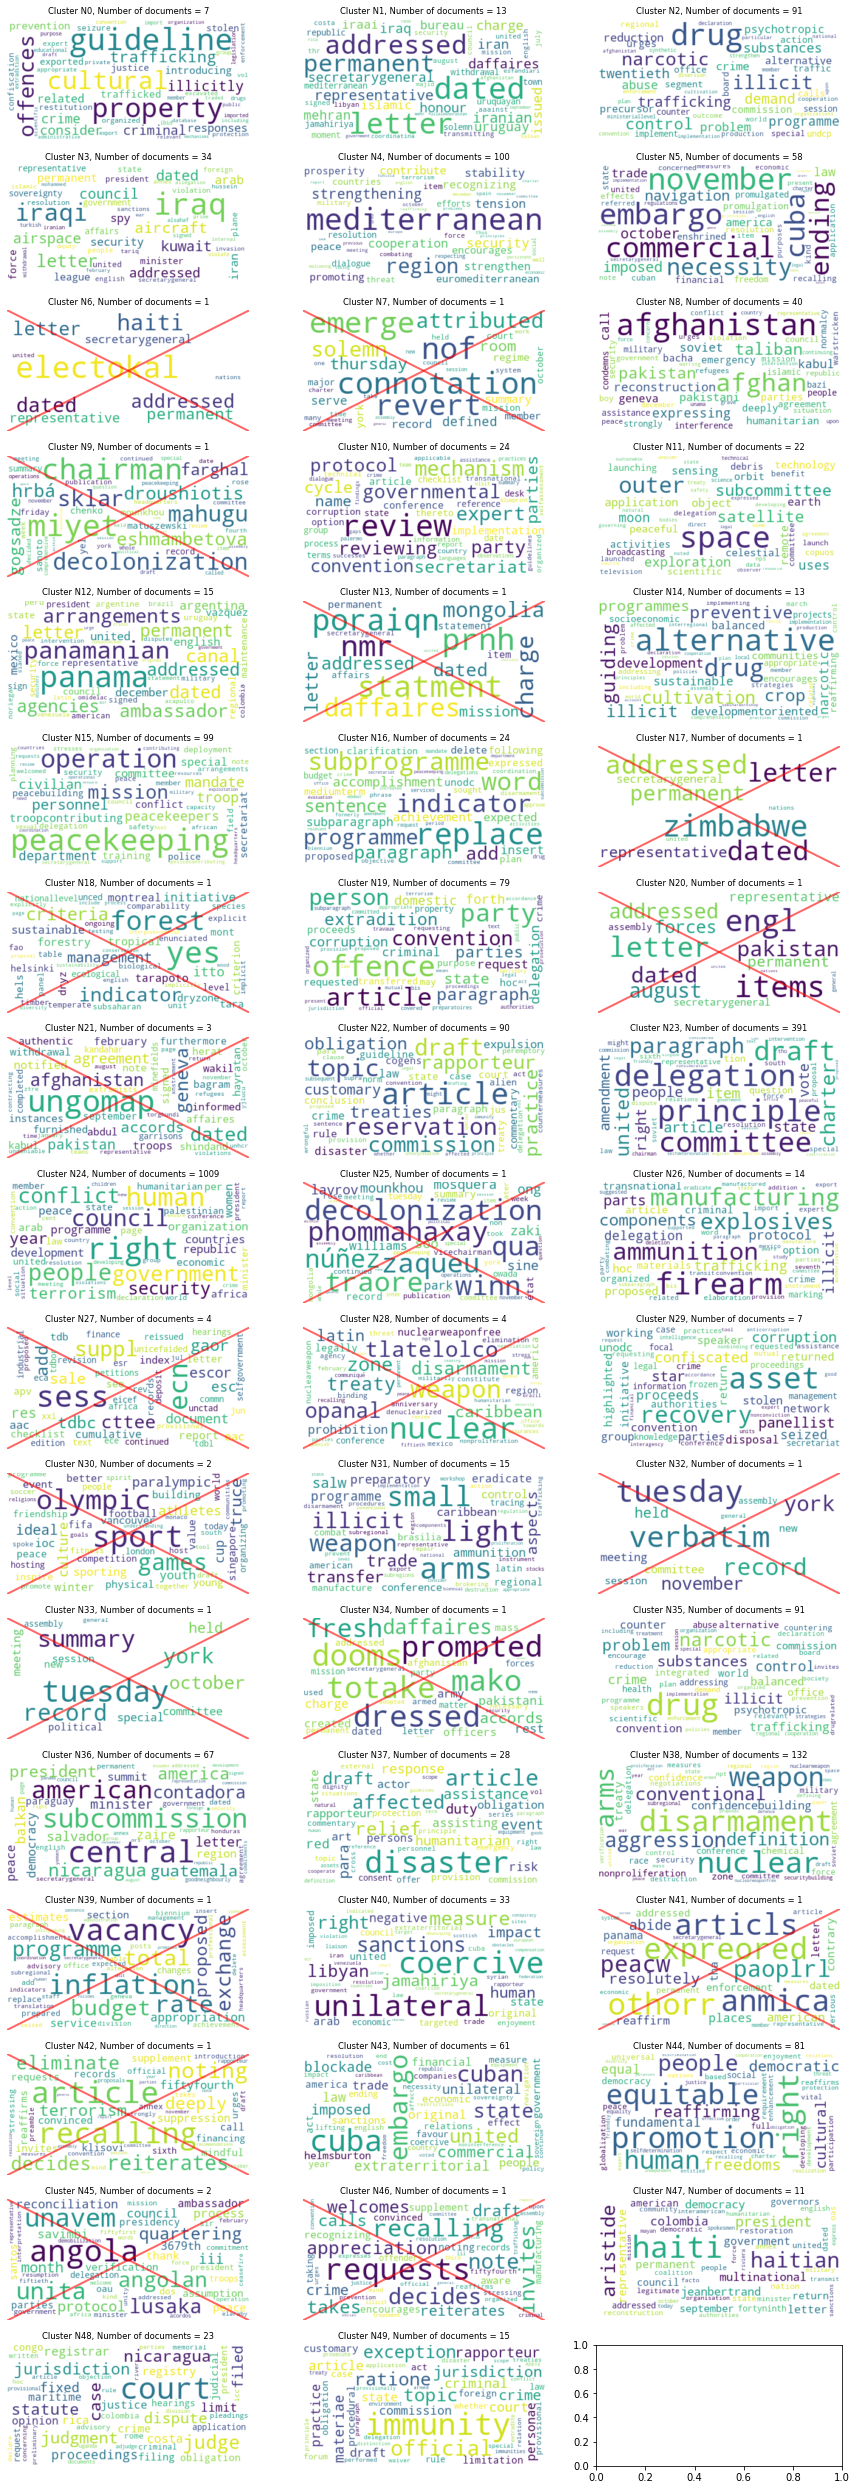

In [23]:
import math
fig, axs = plt.subplots(math.ceil(n_clusters / 3), 3, figsize=(15, 5+int(0.8*n_clusters)))

for k in range(0, n_clusters):
    
    idy = k % 3
    idx = int(k / 3)
    
    center = kmeans_model.cluster_centers_[k]
    center[center < 1e-10] = 0.
    
    if True:
        text = []
        for i in range(number_words):
            text += [all_words[i] for j in range(int(center[i] * 2000.))]
            
    if False:
        text = []
        for i, f in enumerate(all_freq):
            if kmeans_model.labels_[i] == k:
                for w in f:
                    if w in ['united states' or 'united nations']:
                        text += [w.replace(" ", "")]
                    else:
                        text += [w]
                    
    text = ' '.join([word for word in text])
    
    wordcloud = WordCloud(
        max_font_size=50,
        repeat=False,
        max_words=50,
        background_color="white", 
        collocations=False
    ).generate(text)
    
    n_documents = numpy.count_nonzero(kmeans_model.labels_ == k)
    axs[idx, idy].set_title("Cluster N{}, Number of documents = {}".format(
        k, n_documents), size='small'
    )
 
    axs[idx, idy].imshow(wordcloud, interpolation="bilinear")
    
    if n_documents < 5:
        xlim = axs[idx, idy].get_xlim()
        ylim = axs[idx, idy].get_ylim()
        axs[idx, idy].plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], lw=2.0, c='red', alpha=0.6)
        axs[idx, idy].plot([xlim[1], xlim[0]], [ylim[0], ylim[1]], lw=2.0, c='red', alpha=0.6)
        
    axs[idx, idy].set_axis_off()

plt.savefig("clusters.pdf", dpi=100, bbox_inch="tight")
plt.show()

## Document clustering - DBSCAN

2717


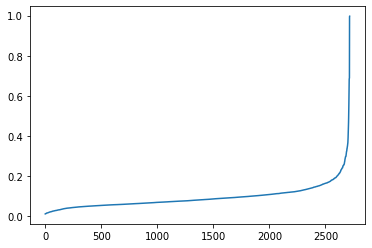

In [27]:
# Find the optimal eps distance
if False:
    from scipy.spatial.distance import cdist 

    _ = [t for t in tfidf]
    print(len(_))
    d = cdist(_, _)

    NN5 = []
    for i in range(len(_)):
        print(i, len(_))
        # Order the distance and remove the first (the diagonal which is 0)
        ordered_dist = sorted(d[i])
        NN5.append(numpy.mean(ordered_dist[1:6]))

    plt.plot(sorted(NN5))

In [25]:
from sklearn.cluster import DBSCAN
# Min_samples: behaviour toward outliers
# eps: bias-variance tradeoff
clustering = DBSCAN(eps=0.07, min_samples=8, n_jobs=4).fit(tfidf)

labels = clustering.labels_
n_clusters = len(set(clustering.labels_))

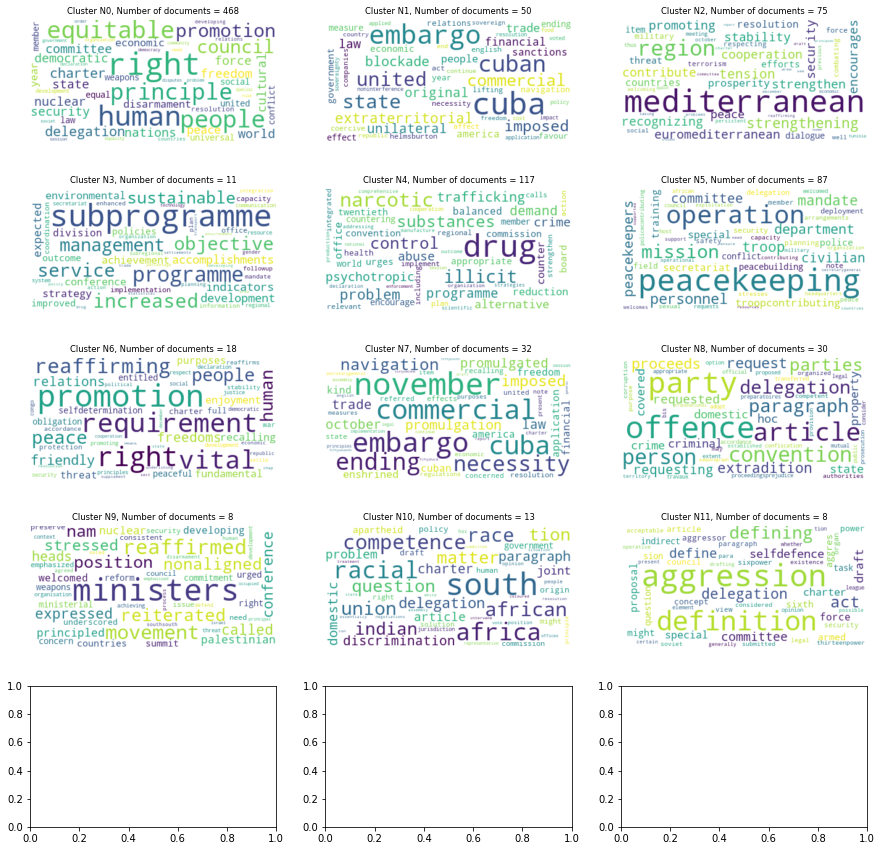

In [26]:
import math
fig, axs = plt.subplots(math.ceil(n_clusters / 3), 3, figsize=(15, 5+int(0.8*n_clusters)), squeeze=False)

for k in range(0, n_clusters):
    
    idy = k % 3
    idx = int(k / 3)
    
    if [f for i, f in enumerate(tfidf) if clustering.labels_[i] == k]:

        center = numpy.mean([f for i, f in enumerate(tfidf) if clustering.labels_[i] == k], axis=0)
        text = []
        for i in range(number_words):
            text += [all_words[i] for j in range(int(center[i] * 2000.))]     
        text = ' '.join([word for word in text])

        wordcloud = WordCloud(
            max_font_size=50,
            repeat=False,
            max_words=50,
            background_color="white", 
            collocations=False
        ).generate(text)

        n_documents = numpy.count_nonzero(clustering.labels_ == k)
        axs[idx, idy].set_title("Cluster N{}, Number of documents = {}".format(
            k, n_documents), size='small'
        )

        axs[idx, idy].imshow(wordcloud, interpolation="bilinear")

        if n_documents < 5:
            xlim = axs[idx, idy].get_xlim()
            ylim = axs[idx, idy].get_ylim()
            axs[idx, idy].plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], lw=2.0, c='red', alpha=0.6)
            axs[idx, idy].plot([xlim[1], xlim[0]], [ylim[0], ylim[1]], lw=2.0, c='red', alpha=0.6)

        axs[idx, idy].set_axis_off()

plt.savefig("clusters_DBSCAN.pdf", dpi=100, bbox_inch="tight")
plt.show()

## Document clustering - Latent Dirichlet allocation

http://www.columbia.edu/~jwp2128/Papers/HoffmanBleiWangPaisley2013.pdf

In [31]:
from sklearn.decomposition import LatentDirichletAllocation

number_topics = 10
n_top_words = 10

lda = LatentDirichletAllocation(n_components=number_topics, n_jobs=4)
lda.fit(tfidf)

for topic_idx, topic in enumerate(lda.components_):
    print("\nTopic #%d:" % topic_idx)
    print(" ".join([all_words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #0:
rpecific pkbjh weaponn jpjh ume freedome ooneral demooratia aotr unchecked

Topic #1:
rpecific pkbjh weaponn jpjh ume freedome ooneral demooratia aotr unchecked

Topic #2:
rpecific pkbjh weaponn jpjh ume freedome ooneral demooratia aotr unchecked

Topic #3:
articls peacw othorr expreored anmica paoplrl resolutely abide places contrary

Topic #4:
rpecific pkbjh weaponn jpjh ume freedome ooneral demooratia aotr unchecked

Topic #5:
rpecific pkbjh weaponn jpjh ume freedome ooneral demooratia aotr unchecked

Topic #6:
electokal weaponn pkbjh rpecific jpjh ume tortor ooneral aotr unchecked

Topic #7:
rpecific pkbjh weaponn jpjh ume freedome ooneral demooratia aotr unchecked

Topic #8:
statment poraiqn prnh nmr charge daffaires mongolia pkbjh jpjh weaponn

Topic #9:
rpecific pkbjh weaponn jpjh ume freedome ooneral demooratia aotr unchecked

Topic #10:
dressed totake dooms prompted mako fresh rest created accords pakistani

Topic #11:
rpecific pkbjh weaponn jpjh ume freedome oonera

##  Third step - Document classification

In [ ]:
# To find the context, take the cosine distance of the text with the "boolean" context